In [2]:
# inputs (per fold, from train_model_cv.py): indices.npy, preds.npy, features.npy, labels.npy
# output: cleanlab results for data issues

# https://docs.cleanlab.ai/stable/tutorials/image.html

In [1]:
import torch
import numpy as np
import pandas as pd
from cleanlab import Datalab

/home/squid/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
indices_list = []
embeddings_list = []
pred_probs_list = []

input_dir = "../cleanlab/outputs/"

for i in range(1,6):
    indices_list.extend(np.load(f"{input_dir}resnet34_indices_fold_{i}.npy"))
    embeddings_list.extend(np.load(f"{input_dir}resnet34_features_fold_{i}.npy"))
    pred_probs_list.extend(np.load(f"{input_dir}resnet34_preds_fold_{i}.npy"))

In [3]:
len(pred_probs_list)

200000

In [8]:
# embeddings_list = np.concatenate(embeddings_list, axis=0)
# pred_probs_list = np.concatenate(pred_probs_list, axis=0)

# rearrange by indice
features = np.empty_like(embeddings_list)
preds = np.empty_like(pred_probs_list)

for i, idx in enumerate(indices_list):
    features[idx] = embeddings_list[i]
    preds[idx] = pred_probs_list[i]

features.shape, preds.shape

((200000, 512), (200000, 2))

In [5]:
# load images
ims_path = '../data/combined_images_parasite_and_non-parasite.npy'
label_path = '../data/combined_ann_parasite_and_non-parasite.csv'

images = np.load(ims_path)
labels_df = pd.read_csv(label_path, index_col='index')
labels = labels_df['annotation'].values

In [10]:
# TODO: testing with 200,000 images
labels = labels[:200000]
images = images[:200000]

In [6]:
dataset = {'image': images, 'label': labels}

find issues

In [9]:
lab = Datalab(data=dataset, label_name="label", image_key="image")
lab.find_issues(features=features, pred_probs=preds)

: 

In [ ]:
lab.report()

label issues

In [11]:
# Use cleanlab to find label issues
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    labels,
    preds,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n {ranked_label_issues[:15]}")

Cleanlab found 5 label issues.
Top 15 most likely label errors: 
 [ 45381  97805  78254 105971  78434]


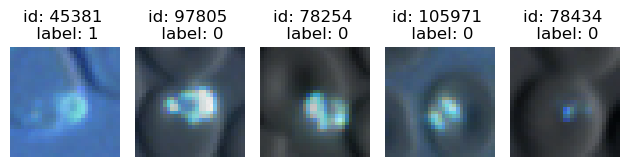

[ 45381  97805  78254 105971  78434]


In [14]:
# display the images
import matplotlib.pyplot as plt

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):

        frame = images[id]
        frame = frame.transpose(1,2,0)
        img_fluorescence = frame[:,:,[2,1,0]]
        img_dpc = frame[:,:,3]
        img_dpc = np.dstack([img_dpc,img_dpc,img_dpc])
        img_overlay = 0.64*img_fluorescence + 0.36*img_dpc

        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(img_overlay)
        plt.title(f"id: {id} \n label: {labels[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)
    plt.show()

plot_examples(ranked_label_issues[range(len(ranked_label_issues))], 3, 5)

print(ranked_label_issues)
np.save(str(len(ranked_label_issues)) + ' possible label issues.npy',images[ranked_label_issues])